<a href="https://www.kaggle.com/code/leoelieson/sropmnist?scriptVersionId=235566531" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://colab.research.google.com/github/ClemButterscotch/SROP/blob/main/SROP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score # Ensure accuracy_score is imported
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# Define FLOP estimation functions for universal algorithmic work measurement
def kmeans_flops(n_samples, n_features, n_clusters, n_iterations):
    """Estimate FLOPs for KMeans: 2 * n_samples * n_clusters * n_features per iteration"""
    return int(2 * n_samples * n_clusters * n_features * n_iterations)

def pca_flops(n_samples, n_features):
    """Estimate FLOPs for PCA via SVD: 2*m*n^2 + (4/3)*n^3"""
    return int(2 * n_samples * n_features**2 + (4/3) * n_features**3)

def ridge_flops(n_samples, n_features):
    """Estimate FLOPs for Ridge solve: 2*m*n^2 + (2/3)*n^3"""
    return int(2 * n_samples * n_features**2 + (2/3) * n_features**3)

def knn_flops(n_train, n_test, n_features):
    """Estimate FLOPs for KNN prediction: 2 * n_train * n_features per test sample"""
    return int(2 * n_train * n_features * n_test)


In [5]:
import kagglehub

mnist_dataset_path = kagglehub.dataset_download('hojjatk/mnist-dataset')

/Users/leo/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import os, struct, gzip, numpy as np

def _smart_open(path):
    # transparently handle .gz files
    return gzip.open(path, 'rb') if path.endswith('.gz') else open(path, 'rb')

def find_file(base_path, fname):
    """Return the real file, no matter how Kaggle wrapped it."""
    direct = os.path.join(base_path, fname)                 # /…/fname
    wrapped = os.path.join(base_path, fname, fname)         # /…/fname/fname
    for p in (direct, direct + '.gz', wrapped, wrapped + '.gz'):
        if os.path.isfile(p):
            return p
    raise FileNotFoundError(f'{fname} not found under {base_path}')

def load_images(path):
    with _smart_open(path) as f:
        magic, size = struct.unpack(">II", f.read(8))
        rows, cols  = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(rows * cols * size), dtype=np.uint8)
        return data.reshape(size, rows * cols)

def load_labels(path):
    with _smart_open(path) as f:
        _, size = struct.unpack(">II", f.read(8))
        return np.frombuffer(f.read(size), dtype=np.uint8)

def load_mnist_data(base_path):
    X_train = load_images(find_file(base_path, 'train-images-idx3-ubyte'))
    y_train = load_labels(find_file(base_path, 'train-labels-idx1-ubyte'))
    X_test  = load_images(find_file(base_path, 't10k-images-idx3-ubyte'))
    y_test  = load_labels(find_file(base_path, 't10k-labels-idx1-ubyte'))
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_mnist_data(mnist_dataset_path)
print(X_train.shape, y_train.shape)   # (60000, 784) (60000,)

(60000, 784) (60000,)


(60000, 784)


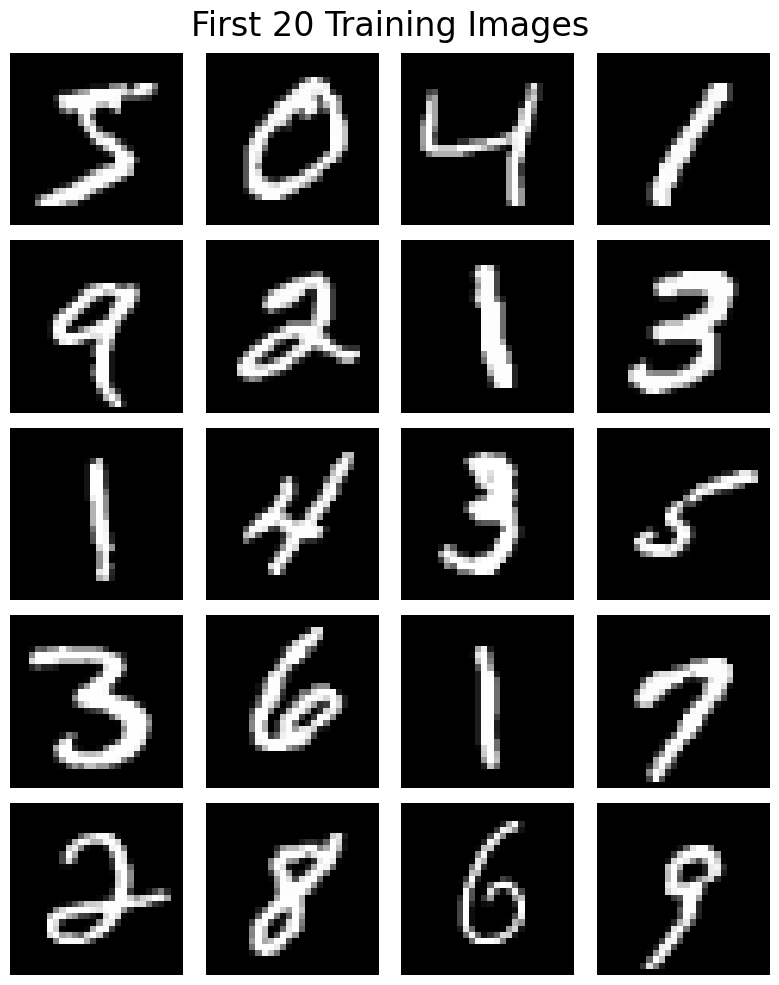

In [10]:
def plot_digits(X, rows=4, cols=5, title="Sample Training Images"):
    """
    Show images in a grid with specified rows and columns.

    Parameters
    ----------
    X : arraylike, shape (n_samples, 784)
        Each row is a 28×28 image flattened to length 784.
    rows : int, optional
        Number of rows in the grid.
    cols : int, optional
        Number of columns in the grid.
    title : str
        Figure title.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(8, 10))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(X):
            ax.imshow(X[i].reshape(28, 28), cmap="gray")
        ax.axis("off")

    fig.suptitle(title, fontsize=24)
    plt.tight_layout()
    plt.show()


print(X_train.shape)        # (60000, 784)
plot_digits(X_train, rows=5, cols=4, title="First 20 Training Images")

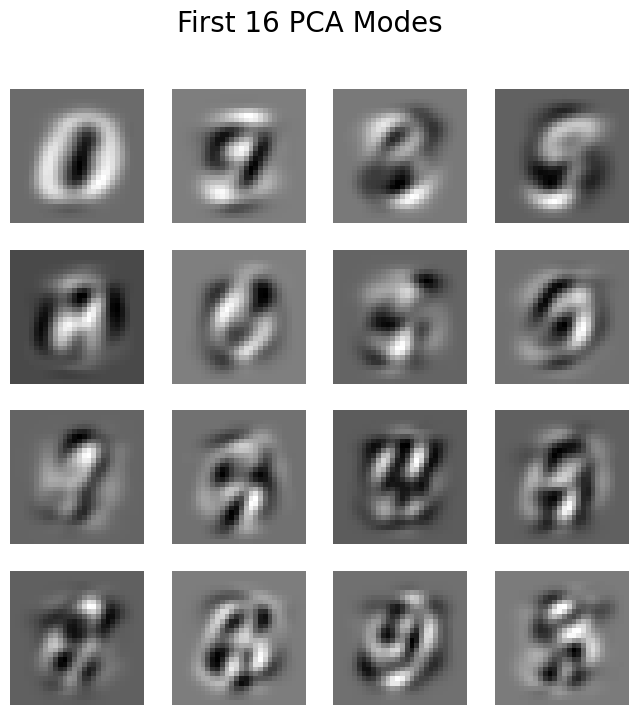

In [7]:
pca = PCA()
pca.fit(X_train)
pc_modes = pca.components_[:16]

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i in range(4):
    for j in range(4):
        idx = i * 4 + j
        axs[i, j].imshow(pc_modes[idx].reshape(28, 28), cmap="gray")
        axs[i, j].axis("off")
fig.suptitle("First 16 PCA Modes", fontsize=20)
plt.show()

In [8]:
# Compute FLOPs for the initial PCA fit
m, n = X_train.shape
flops_pca = pca_flops(m, n)
print(f"PCA FLOPs (m={m}, n={n}): {flops_pca}")


PCA FLOPs (m=60000, n=784): 74401240405


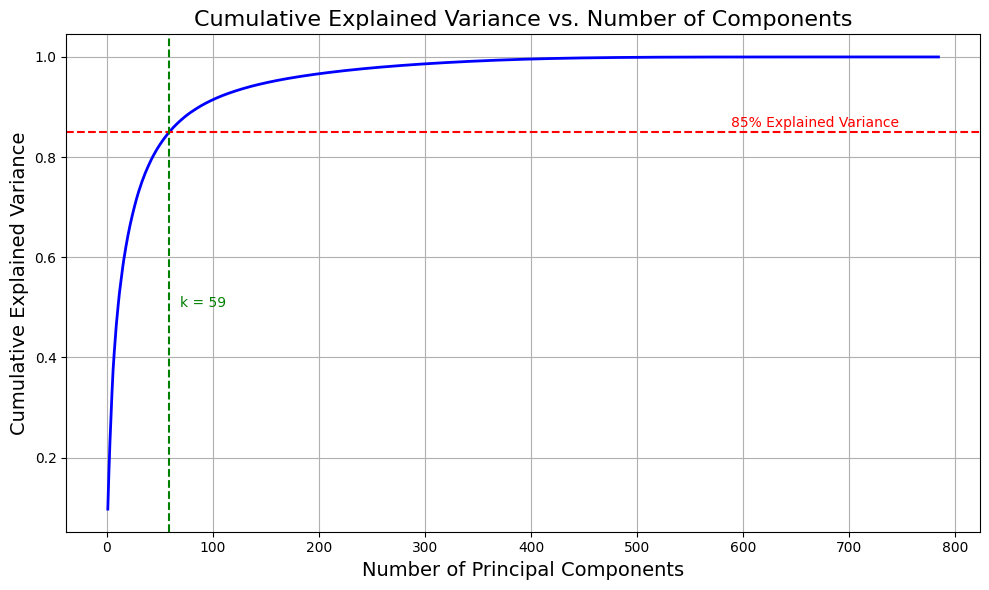

59


In [9]:
Sigma = pca.singular_values_

energy = np.power(Sigma, 2) / np.sum(np.power(Sigma, 2))
cumulative_energy = np.cumsum(energy)
# Plot cumulative energy (variance explained)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_energy) + 1), cumulative_energy, 'b-', linewidth=2)
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.title('Cumulative Explained Variance vs. Number of Components', fontsize=16)
plt.grid(True)

# Add a horizontal line at 85% for reference
plt.axhline(y=0.85, color='r', linestyle='--')
plt.text(len(cumulative_energy) * 0.75, 0.86, '85% Explained Variance', color='r')

# Mark the optimal k value (where we reach 85% variance)
k = np.argmax(cumulative_energy >= 0.85) + 1
plt.axvline(x=k, color='g', linestyle='--')
plt.text(k + 10, 0.5, f'k = {k}', color='g')

plt.tight_layout()
plt.show()
print(k)

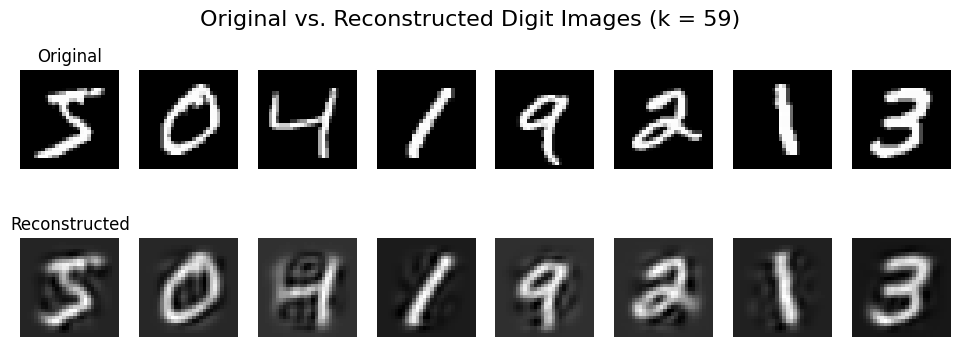

In [10]:
pca_k = PCA(n_components=k)
Xtrain_reduced = pca_k.fit_transform(X_train)
Xtrain_reconstructed = pca_k.inverse_transform(Xtrain_reduced)

num_images = 8
fig, axs = plt.subplots(2, num_images, figsize=(num_images * 1.5, 4))
for i in range(num_images):
    axs[0, i].imshow(X_train[i].reshape(28, 28), cmap="gray")
    axs[0, i].axis("off")
    if i == 0:
        axs[0, i].set_title("Original", fontsize=12)
    # Reconstruction below
    axs[1, i].imshow(Xtrain_reconstructed[i].reshape(28, 28), cmap="gray")
    axs[1, i].axis("off")
    if i == 0:
        axs[1, i].set_title("Reconstructed", fontsize=12)

fig.suptitle("Original vs. Reconstructed Digit Images (k = {})".format(k), fontsize=16)
plt.show()


In [11]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

--- K-Means Clustering on Original Data ---


/Users/leo/Library/Python/3.11/lib/python/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


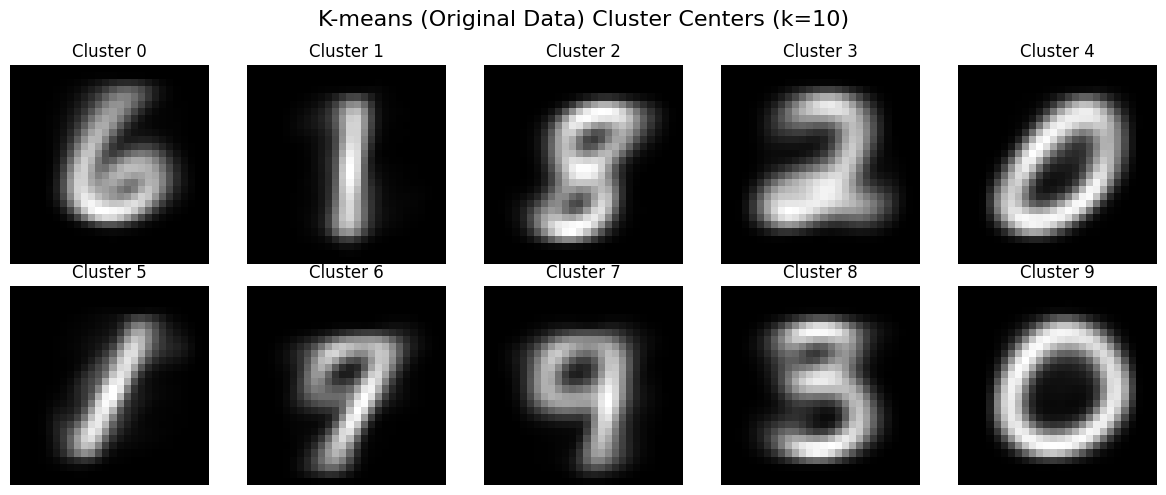

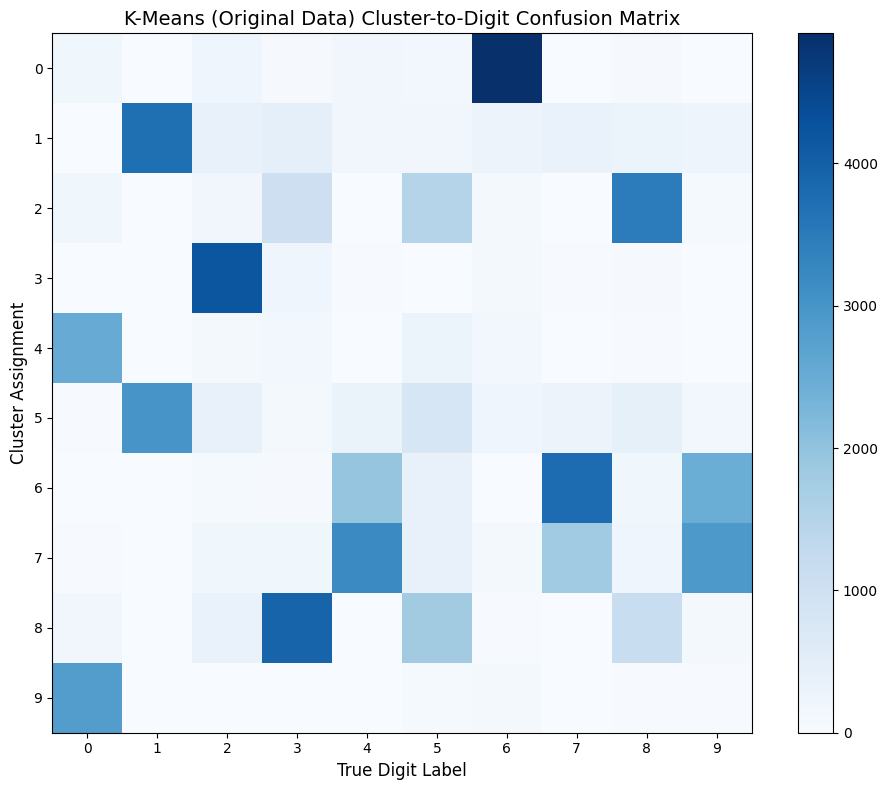

K-Means (Original Data) Wall-clock time: 48.5791 seconds
K-Means (Original Data) Accuracy (mapped to y_train): 0.5908
K-Means (Original Data) FLOPs: 5.74e+10


In [12]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from scipy.stats import mode # Ensure mode is imported
import time # Import time

# Apply K-means on Original data
print("--- K-Means Clustering on Original Data ---")
n_clusters = 10  # Since we have 10 digits/classes
kmeans_original_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

start_time = time.time()
# Fit on original X_train data
kmeans_original_cluster_labels = kmeans_original_model.fit_predict(X_train)
kmeans_original_time = time.time() - start_time

# Visualize cluster centers as images
# For visualization, project original data centers to PCA space if desired, or visualize directly
# If visualizing original centers, they are already in the original feature space.
# centers_original = kmeans_original_model.cluster_centers_
# Project the cluster centers through PCA for better visualization (optional, if centers are high-dim)
# This part was for PCA-reduced data's centers. For original data, centers are in 784-dim space.
# For consistency with the original cell's intent to visualize, we can show them.
# However, the prompt's focus is on metrics.
# Let's keep the visualization part as it was, but note it's about visualizing centers.
# The original cell's visualization was:
# centers = kmeans.cluster_centers_
# centers_pca = pca_k.transform(centers) # This assumes centers are from original data space
# reconstructed_centers = pca_k.inverse_transform(centers_pca)
# This is fine if kmeans_original_model.cluster_centers_ are used.

centers_original_space = kmeans_original_model.cluster_centers_
# To visualize these 784-dim centers, they can be reshaped directly.
# If we want to show them "as seen by PCA" (like the original cell did for some reason):
# centers_pca_transformed = pca_k.transform(centers_original_space) # Transform to k-dim PCA space
# reconstructed_centers_from_original = pca_k.inverse_transform(centers_pca_transformed) # Transform back to 784-dim image space

plt.figure(figsize=(12, 5))
for i in range(n_clusters):
    plt.subplot(2, 5, i+1)
    # plt.imshow(reconstructed_centers_from_original[i].reshape(28, 28), cmap="gray") # if using PCA reconstruction for viz
    plt.imshow(centers_original_space[i].reshape(28, 28), cmap="gray") # Direct visualization
    plt.title(f'Cluster {i}')
    plt.axis('off')
plt.suptitle('K-means (Original Data) Cluster Centers (k=10)', fontsize=16)
plt.tight_layout()
plt.show()

# Evaluate clusters by comparing with true labels
# For each cluster, find the most common digit
clusters_to_digits_original = {}
y_pred_kmeans_original = np.zeros_like(kmeans_original_cluster_labels) # For accuracy calculation

for i in range(n_clusters):
    mask = (kmeans_original_cluster_labels == i)
    cluster_labels_true = y_train[mask]
    if len(cluster_labels_true) > 0:
        mode_result = mode(cluster_labels_true)
        most_common = mode_result[0][0] if hasattr(mode_result[0], '__iter__') else mode_result[0]
        clusters_to_digits_original[i] = most_common
        y_pred_kmeans_original[mask] = most_common # Assign mapped label

# Create a confusion matrix between clusters and true labels
cluster_confusion_original = np.zeros((n_clusters, 10), dtype=int)
for i, true_label in enumerate(y_train):
    cluster = kmeans_original_cluster_labels[i]
    cluster_confusion_original[cluster, true_label] += 1

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cluster_confusion_original, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('K-Means (Original Data) Cluster-to-Digit Confusion Matrix', fontsize=14)
plt.colorbar()
plt.xlabel('True Digit Label', fontsize=12)
plt.ylabel('Cluster Assignment', fontsize=12)
plt.xticks(range(10))
plt.yticks(range(n_clusters))
plt.tight_layout()
plt.show()

# Calculate clustering accuracy (using the most common digit in each cluster)
kmeans_original_accuracy = accuracy_score(y_train, y_pred_kmeans_original)

# Compute FLOPs for KMeans clustering on original data
g_n_orig, g_f_orig = X_train.shape
k_clusters_orig = kmeans_original_model.n_clusters
iters_orig = kmeans_original_model.n_iter_
kmeans_original_flops = kmeans_flops(g_n_orig, g_f_orig, k_clusters_orig, iters_orig)

print(f"K-Means (Original Data) Wall-clock time: {kmeans_original_time:.4f} seconds")
print(f"K-Means (Original Data) Accuracy (mapped to y_train): {kmeans_original_accuracy:.4f}")
print(f"K-Means (Original Data) FLOPs: {kmeans_original_flops:.2e}")

In [13]:
# This cell's content has been moved to cell a40878f2.
# It can be deleted.
# Original content:
# # Compute FLOPs for KMeans clustering
# g_n, g_f = X_train.shape
# k = kmeans.n_clusters
# iters = kmeans.n_iter_
# flops_km = kmeans_flops(g_n, g_f, k, iters)
# print(f"KMeans FLOPs (clusters={k}, iterations={iters}): {flops_km}")
print("Content of this cell (KMeans FLOPs for original data) moved to the K-Means (Original Data) cell above.")

Content of this cell (KMeans FLOPs for original data) moved to the K-Means (Original Data) cell above.



--- K-Means Clustering with PCA ---
K-Means (PCA) Wall-clock time: 7.1654 seconds
K-Means (PCA) Accuracy (mapped to y_train): 0.5828
K-Means (PCA) FLOPs: 5.38e+09

--- Ridge Classifier with PCA ---
Ridge (PCA) Fit Wall-clock time: 0.1356 seconds
Ridge (PCA) Predict Wall-clock time: 0.0044 seconds
Ridge (PCA) Total Wall-clock time: 0.1400 seconds
Ridge (PCA) Test Accuracy: 0.8561
Ridge (PCA) FLOPs: 4.18e+08

--- KNN Classifier with PCA ---
KNN (PCA) Fit Wall-clock time: 0.0103 seconds
KNN (PCA) Predict Wall-clock time: 1.7397 seconds
KNN (PCA) Total Wall-clock time: 1.7500 seconds
KNN (PCA) Test Accuracy: 0.9760
KNN (PCA) FLOPs: 7.08e+10


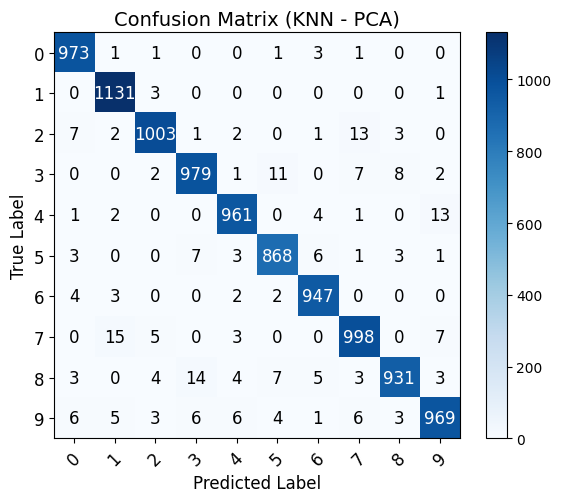

In [14]:
# Ensure X_train, y_train, X_test, y_test, pca_k, n_clusters are defined
# Xtrain_pca, Xtest_pca should be created here or be available
# k variable (number of PCA components) should be available from cell 20d939f3
# n_clusters from cell a40878f2

import time
import numpy as np
from scipy.stats import mode
from sklearn.cluster import KMeans # Already imported but good for clarity
from sklearn.linear_model import RidgeClassifier # Already imported
from sklearn.neighbors import KNeighborsClassifier # Already imported
from sklearn.metrics import accuracy_score # Already imported
# FLOPs functions (kmeans_flops, ridge_flops, knn_flops) are defined in cell 4d619a61

Xtrain_pca = pca_k.transform(X_train) # pca_k is PCA(n_components=k) from cell 4b3fbd7f
Xtest_pca = pca_k.transform(X_test)   # k is optimal components from cell 20d939f3

# --- K-Means Clustering with PCA ---
print("\n--- K-Means Clustering with PCA ---")
# n_clusters is defined in cell a40878f2, typically 10
kmeans_pca_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
start_time = time.time()
kmeans_pca_model.fit(Xtrain_pca)
kmeans_pca_time = time.time() - start_time

# Calculate K-Means (PCA) accuracy by mapping cluster labels to true y_train labels
kmeans_pca_cluster_labels = kmeans_pca_model.labels_
y_pred_kmeans_pca = np.zeros_like(kmeans_pca_cluster_labels)
for i in range(n_clusters):
    mask = (kmeans_pca_cluster_labels == i)
    if np.any(mask):
        true_labels_in_cluster = y_train[mask] # Use y_train for mapping
        if true_labels_in_cluster.size > 0:
            mode_result = mode(true_labels_in_cluster)
            y_pred_kmeans_pca[mask] = mode_result[0][0] if hasattr(mode_result[0], '__iter__') else mode_result[0]
kmeans_pca_accuracy = accuracy_score(y_train, y_pred_kmeans_pca)

# FLOPs for K-Means (PCA)
kmeans_pca_flops = kmeans_flops(Xtrain_pca.shape[0], Xtrain_pca.shape[1], kmeans_pca_model.n_clusters, kmeans_pca_model.n_iter_)

print(f"K-Means (PCA) Wall-clock time: {kmeans_pca_time:.4f} seconds")
print(f"K-Means (PCA) Accuracy (mapped to y_train): {kmeans_pca_accuracy:.4f}")
print(f"K-Means (PCA) FLOPs: {kmeans_pca_flops:.2e}")


# --- Ridge Classifier with PCA ---
print("\n--- Ridge Classifier with PCA ---")
ridge_pca_model = RidgeClassifier(random_state=42) # Renamed from 'ridge'

# CV score (optional, kept from original cell)
# ridge_cv = cross_val_score(ridge_pca_model, Xtrain_pca, y_train, cv=5) 
# print(f"Ridge (PCA) - CV Accuracy: {ridge_cv.mean():.3f}") # Original print

start_time_fit = time.time()
ridge_pca_model.fit(Xtrain_pca, y_train)
ridge_pca_fit_time = time.time() - start_time_fit

start_time_predict = time.time()
y_pred_ridge_pca = ridge_pca_model.predict(Xtest_pca)
ridge_pca_predict_time = time.time() - start_time_predict

ridge_pca_time = ridge_pca_fit_time + ridge_pca_predict_time
ridge_pca_accuracy = accuracy_score(y_test, y_pred_ridge_pca) # Renamed from ridge_acc, using accuracy_score

# FLOPs for Ridge (PCA)
ridge_pca_fit_flops = ridge_flops(Xtrain_pca.shape[0], Xtrain_pca.shape[1])
ridge_pca_predict_flops = Xtest_pca.shape[0] * Xtest_pca.shape[1] # M_test * D_pca
ridge_pca_flops = ridge_pca_fit_flops + ridge_pca_predict_flops

print(f"Ridge (PCA) Fit Wall-clock time: {ridge_pca_fit_time:.4f} seconds")
print(f"Ridge (PCA) Predict Wall-clock time: {ridge_pca_predict_time:.4f} seconds")
print(f"Ridge (PCA) Total Wall-clock time: {ridge_pca_time:.4f} seconds")
print(f"Ridge (PCA) Test Accuracy: {ridge_pca_accuracy:.4f}")
print(f"Ridge (PCA) FLOPs: {ridge_pca_flops:.2e}")


# --- KNN Classifier with PCA ---
print("\n--- KNN Classifier with PCA ---")
knn_pca_model = KNeighborsClassifier(n_neighbors=5) # Renamed from 'knn'

# CV score (optional, kept from original cell)
# knn_cv = cross_val_score(knn_pca_model, Xtrain_pca, y_train, cv=5)
# print(f"KNN (PCA) - CV Accuracy: {knn_cv.mean():.3f}") # Original print

start_time_fit = time.time()
knn_pca_model.fit(Xtrain_pca, y_train)
knn_pca_fit_time = time.time() - start_time_fit # Usually negligible

start_time_predict = time.time()
y_pred_knn_pca = knn_pca_model.predict(Xtest_pca) # y_pred_knn was used in original cell
knn_pca_predict_time = time.time() - start_time_predict

knn_pca_time = knn_pca_fit_time + knn_pca_predict_time
knn_pca_accuracy = accuracy_score(y_test, y_pred_knn_pca) # Renamed from knn_acc

# FLOPs for KNN (PCA)
# Fit FLOPs are negligible for KNN.
knn_pca_predict_flops = knn_flops(Xtrain_pca.shape[0], Xtest_pca.shape[0], Xtrain_pca.shape[1])
knn_pca_flops = knn_pca_predict_flops # Assuming fit FLOPs are 0

print(f"KNN (PCA) Fit Wall-clock time: {knn_pca_fit_time:.4f} seconds")
print(f"KNN (PCA) Predict Wall-clock time: {knn_pca_predict_time:.4f} seconds")
print(f"KNN (PCA) Total Wall-clock time: {knn_pca_time:.4f} seconds")
print(f"KNN (PCA) Test Accuracy: {knn_pca_accuracy:.4f}")
print(f"KNN (PCA) FLOPs: {knn_pca_flops:.2e}")

# Original confusion matrix plot for KNN (PCA)
cm_multi_knn_pca = confusion_matrix(y_test, y_pred_knn_pca)
classes_knn_pca = np.unique(y_test) # Ensure np is available
# plot_confusion_matrix function is defined in cell 29e894c7
plot_confusion_matrix(cm_multi_knn_pca, classes=classes_knn_pca, title='Confusion Matrix (KNN - PCA)')

In [15]:
# This cell's content (FLOPs for Ridge and KNN on PCA) has been moved to cell 4bd660ed.
# It can be deleted.
# Original content:
# # Compute FLOPs for Ridge training and KNN prediction
# n_train, n_feat = Xtrain_pca.shape
# n_test = Xtest_pca.shape[0]
# flops_ridge_val = ridge_flops(n_train, n_feat)
# flops_knn_val = knn_flops(n_train, n_test, n_feat)
# print(f"Ridge training FLOPs (m={n_train}, n={n_feat}): {flops_ridge_val}")
# print(f"KNN prediction FLOPs (train={n_train}, test={n_test}, features={n_feat}): {flops_knn_val}")
print("Content of this cell (Ridge/KNN PCA FLOPs) moved to the PCA-based Classifiers cell above.")

Content of this cell (Ridge/KNN PCA FLOPs) moved to the PCA-based Classifiers cell above.


In [16]:
# Ensure X_train, y_train, X_test, y_test are defined
# FLOPs functions (ridge_flops) are defined in cell 4d619a61
import time
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score

print("\n--- Ridge Classifier on Original Data ---")
ridge_original_model = RidgeClassifier(random_state=42)

start_time_fit = time.time()
ridge_original_model.fit(X_train, y_train)
ridge_original_fit_time = time.time() - start_time_fit

start_time_predict = time.time()
y_pred_ridge_original = ridge_original_model.predict(X_test)
ridge_original_predict_time = time.time() - start_time_predict

ridge_original_time = ridge_original_fit_time + ridge_original_predict_time
ridge_original_accuracy = accuracy_score(y_test, y_pred_ridge_original)

# FLOPs for Ridge (Original Data)
ridge_original_fit_flops = ridge_flops(X_train.shape[0], X_train.shape[1])
ridge_original_predict_flops = X_test.shape[0] * X_train.shape[1] # M_test * D_original
ridge_original_flops = ridge_original_fit_flops + ridge_original_predict_flops

print(f"Ridge (Original) Fit Wall-clock time: {ridge_original_fit_time:.4f} seconds")
print(f"Ridge (Original) Predict Wall-clock time: {ridge_original_predict_time:.4f} seconds")
print(f"Ridge (Original) Total Wall-clock time: {ridge_original_time:.4f} seconds")
print(f"Ridge (Original) Test Accuracy: {ridge_original_accuracy:.4f}")
print(f"Ridge (Original) FLOPs: {ridge_original_flops:.2e}")

# Optional: Confusion Matrix for Ridge (Original)
# from sklearn.metrics import confusion_matrix
# cm_ridge_original = confusion_matrix(y_test, y_pred_ridge_original)
# classes_ridge_original = np.unique(y_test)
# plot_confusion_matrix(cm_ridge_original, classes=classes_ridge_original, title='Confusion Matrix (Ridge - Original)')


--- Ridge Classifier on Original Data ---
Ridge (Original) Fit Wall-clock time: 4.3748 seconds
Ridge (Original) Predict Wall-clock time: 0.0962 seconds
Ridge (Original) Total Wall-clock time: 4.4710 seconds
Ridge (Original) Test Accuracy: 0.8603
Ridge (Original) FLOPs: 7.41e+10


In [17]:
# Ensure X_train, y_train, X_test, y_test are defined
# FLOPs functions (knn_flops) are defined in cell 4d619a61
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

print("\n--- KNN Classifier on Original Data ---")
knn_original_model = KNeighborsClassifier(n_neighbors=5)

start_time_fit = time.time()
knn_original_model.fit(X_train, y_train)
knn_original_fit_time = time.time() - start_time_fit

start_time_predict = time.time()
y_pred_knn_original = knn_original_model.predict(X_test)
knn_original_predict_time = time.time() - start_time_predict

knn_original_time = knn_original_fit_time + knn_original_predict_time
knn_original_accuracy = accuracy_score(y_test, y_pred_knn_original)

# FLOPs for KNN (Original Data)
# Fit FLOPs are negligible.
knn_original_predict_flops = knn_flops(X_train.shape[0], X_test.shape[0], X_train.shape[1])
knn_original_flops = knn_original_predict_flops

print(f"KNN (Original) Fit Wall-clock time: {knn_original_fit_time:.4f} seconds")
print(f"KNN (Original) Predict Wall-clock time: {knn_original_predict_time:.4f} seconds")
print(f"KNN (Original) Total Wall-clock time: {knn_original_time:.4f} seconds")
print(f"KNN (Original) Test Accuracy: {knn_original_accuracy:.4f}")
print(f"KNN (Original) FLOPs: {knn_original_flops:.2e}")

# Optional: Confusion Matrix for KNN (Original)
# from sklearn.metrics import confusion_matrix
# cm_knn_original = confusion_matrix(y_test, y_pred_knn_original)
# classes_knn_original = np.unique(y_test)
# plot_confusion_matrix(cm_knn_original, classes=classes_knn_original, title='Confusion Matrix (KNN - Original)')


--- KNN Classifier on Original Data ---
KNN (Original) Fit Wall-clock time: 0.0142 seconds
KNN (Original) Predict Wall-clock time: 32.6314 seconds
KNN (Original) Total Wall-clock time: 32.6455 seconds
KNN (Original) Test Accuracy: 0.9688
KNN (Original) FLOPs: 9.41e+11


In [18]:
# This cell is now redundant as accuracies are printed within their respective model sections.
# It can be deleted.
# Original content:
# print(f"Ridge Classifier:      {ridge_acc:.3f}")
# print(f"KNN Classifier (k=5):  {knn_acc:.3f}")
print("This cell (printing Ridge/KNN PCA accuracies) is now redundant and can be removed.")

This cell (printing Ridge/KNN PCA accuracies) is now redundant and can be removed.


In [19]:
import pandas as pd

# Consolidate all metrics
# Ensure all these variables have been computed and stored from previous cells.
# For K-Means, accuracy is on y_train (mapped); for Ridge/KNN, accuracy is on y_test.

summary_data = [
    {'Method': 'K-Means', 'Data': 'Original', 
     'Accuracy': kmeans_original_accuracy, 
     'Wall-clock Time (s)': kmeans_original_time, 
     'FLOPs': f"{kmeans_original_flops:.2e}",
     'Accuracy Note': 'Mapped to y_train'},
    {'Method': 'K-Means', 'Data': 'PCA',    
     'Accuracy': kmeans_pca_accuracy,    
     'Wall-clock Time (s)': kmeans_pca_time,    
     'FLOPs': f"{kmeans_pca_flops:.2e}",
     'Accuracy Note': 'Mapped to y_train'},
    
    {'Method': 'Ridge Classifier', 'Data': 'Original', 
     'Accuracy': ridge_original_accuracy, 
     'Wall-clock Time (s)': ridge_original_time, 
     'FLOPs': f"{ridge_original_flops:.2e}",
     'Accuracy Note': 'On y_test'},
    {'Method': 'Ridge Classifier', 'Data': 'PCA',    
     'Accuracy': ridge_pca_accuracy,    
     'Wall-clock Time (s)': ridge_pca_time,    
     'FLOPs': f"{ridge_pca_flops:.2e}",
     'Accuracy Note': 'On y_test'},

    {'Method': 'KNN Classifier', 'Data': 'Original', 
     'Accuracy': knn_original_accuracy, 
     'Wall-clock Time (s)': knn_original_time, 
     'FLOPs': f"{knn_original_flops:.2e}",
     'Accuracy Note': 'On y_test'},
    {'Method': 'KNN Classifier', 'Data': 'PCA',    
     'Accuracy': knn_pca_accuracy,    
     'Wall-clock Time (s)': knn_pca_time,    
     'FLOPs': f"{knn_pca_flops:.2e}",
     'Accuracy Note': 'On y_test'},
]

comparison_df = pd.DataFrame(summary_data)
# Reorder columns for better readability
comparison_df = comparison_df[['Method', 'Data', 'Accuracy', 'Wall-clock Time (s)', 'FLOPs', 'Accuracy Note']]


print("\n--- Comparison Summary ---")
# For cleaner output in notebooks, directly displaying the DataFrame is often preferred.
# print(comparison_df.to_string()) 
comparison_df


--- Comparison Summary ---


,Method,Data,Accuracy,Wall-clock Time (s),FLOPs,Accuracy Note
0,K-Means,Original,0.590800,48.579068,5.74e+10,Mapped to y_train
1,K-Means,PCA,0.582833,7.165390,5.38e+09,Mapped to y_train
2,Ridge Classifier,Original,0.860300,4.470966,7.41e+10,On y_test
3,Ridge Classifier,PCA,0.856100,0.140038,4.18e+08,On y_test
4,KNN Classifier,Original,0.968800,32.645507,9.41e+11,On y_test
5,KNN Classifier,PCA,0.976000,1.750032,7.08e+10,On y_test


In [20]:
import csv # csv module already imported in original cell

# Ensure comparison_df is available from the previous cell.

# Export the comparison table to a CSV file
csv_file_path = 'Fashion-MNIST-metrics-comparison.csv' # New filename
comparison_df.to_csv(csv_file_path, index=False)

# Print a confirmation message
print(f"Comprehensive comparison table saved to '{csv_file_path}' successfully.")

# Original data and CSV creation (now replaced by comparison_df export)
# data = [
#     ["Algorithm","Test Accuracy"],
#     ["k-means",0.553],
#     ["Ridge",0.773],
#     ["KNN",0.857]
# ]
# csv_file_path_original = 'Fashion-MNIST.csv'
# with open(csv_file_path_original, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(data)
# print(f"Original CSV file '{csv_file_path_original}' created successfully.")

Comprehensive comparison table saved to 'Fashion-MNIST-metrics-comparison.csv' successfully.
